# Imports

In [9]:
import catboost as cb
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import xgboost as xgb

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import geopandas as gpd

# Configs

In [10]:
INPUT_PATH = 'datasets/'
ARIMA_PATH = 'statics/arima_predict.parquet'
OUTPUT_PATH = 'results/xgb_predictions.parquet'

RIDGE_TEST_PATH = 'results/ridge_test_predictions.parquet'
RIDGE_TRAIN_PATH = 'results/ridge_train_predictions.parquet'

START_DATE = '2023-01-01'
END_DATE = '2023-04-30'

FEATURE_LIST = ['ARIMA_predicts',
                # 'borough',
                
                # 'Previous_week_trip_dist',
                # 'Previous_2week_trip_dist',
                # 'Previous_day_trip_dist',

                # 'Previous_week_passenger_count',
                # 'Previous_2week_passenger_count',
                # 'Previous_day_passenger_count',

                # 'Previous_week_fare_amount',
                # 'Previous_day_fare_amount',
                # 'Previous_2week_fare_amount',
                #'Ridge_predict',

                'Previous_2week_demand',
                'Previous_week_demand', 

                'Previous_day_demand',
                'Previous_2day_demand',
                'Previous_3day_demand',
                'Previous_4day_demand',
                'Previous_5day_demand',
                'Previous_6day_demand',
                'Previous_8day_demand',
                'Previous_9day_demand',
                'Previous_10day_demand',
                'Previous_11day_demand',
                'Previous_12day_demand',
                'Previous_13day_demand',

                # 'Previous_week_extra',
                # 'Previous_2week_extra',
                # 'Previous_day_extra',
                
                # 'Previous_2week_RatecodeID',
                # 'Previous_week_RatecodeID',
                # 'Previous_day_RatecodeID',

                # 'Previous_week_congestion_surcharge',
                # 'Previous_2week_congestion_surcharge',
                # 'Previous_day_congestion_surcharge',

                # 'Day_of_month', 
                # 'Day_of_week',
                # 'Location'
                ]

TEST_START_DATE = '2023-04-01'

AUTO_TUNE = False

# Data preparation


## Load Data

In [11]:
def load_data(path, start_date: str, end_date: str):
    df = pd.read_parquet(path)
    start_date = datetime.date.fromisoformat(start_date)
    end_date = datetime.date.fromisoformat(end_date)
    filtered_df = df[(df['tpep_pickup_datetime'].dt.date >= start_date) &
                     (df['tpep_pickup_datetime'].dt.date <= end_date)]
    dataset = filtered_df.filter(items=['tpep_pickup_datetime', 'PULocationID'])
    dataset['PU_date'] = pd.to_datetime(dataset['tpep_pickup_datetime'].dt.date)
    return dataset

In [12]:
rides_df = load_data(INPUT_PATH, START_DATE, END_DATE)

In [13]:
print(f'rides dataframe shape : {rides_df.shape}')
rides_df.head()

rides dataframe shape : (12672629, 3)


,tpep_pickup_datetime,PULocationID,PU_date
0,2023-01-01 00:32:10,161,2023-01-01
1,2023-01-01 00:55:08,43,2023-01-01
2,2023-01-01 00:25:04,48,2023-01-01
3,2023-01-01 00:03:48,138,2023-01-01
4,2023-01-01 00:10:29,107,2023-01-01


In [14]:
ridge_train_df = pd.read_parquet(RIDGE_TRAIN_PATH)
ridge_test_df = pd.read_parquet(RIDGE_TEST_PATH)
ridge_df = pd.concat([ridge_train_df, ridge_test_df], axis = 0)

In [15]:
print(f'ridge dataframe shape : {ridge_df.shape}')
ridge_df.head()

ridge dataframe shape : (27772, 3)


,Location,Date,Predicted_demand
0,1,2023-01-15,21.068408
1,1,2023-01-16,24.384333
2,1,2023-01-17,16.425526
3,1,2023-01-18,14.017839
4,1,2023-01-19,14.114395


In [16]:
arima_df = pd.read_parquet(ARIMA_PATH)

In [17]:
print(f'rides dataframe shape : {arima_df.shape}')
arima_df.head()


rides dataframe shape : (27772, 1)


,0
0,18
1,0
2,1
3,86
4,1


In [18]:
regions_df = gpd.read_file('taxi_zones/taxi_zones.shp')
regions_df = regions_df.rename(columns = {'LocationID' : 'Location'})

In [19]:
regions_df['borough']

0                EWR
1             Queens
2              Bronx
3          Manhattan
4      Staten Island
           ...      
258            Bronx
259           Queens
260        Manhattan
261        Manhattan
262        Manhattan
Name: borough, Length: 263, dtype: object

## Labeling

In [20]:
def labeling(dataset, zones):
    dataset_labels = (
        dataset
        .groupby(['PULocationID', 'PU_date'])['PU_date']
        .count()
        .to_frame('Demand')
        .sort_values(['PULocationID', 'PU_date'], ascending=[True, True])
        .reset_index()
        .rename(columns={'PULocationID': 'Location', 'PU_date': 'Date'})
    )

    locations = pd.DataFrame(dataset_labels['Location'].unique(), columns=['Location'])
    dates = pd.DataFrame(dataset_labels['Date'].unique(), columns=['Date'])

    location_date_df = (
        locations
        .merge(dates, how='cross')
        .sort_values(['Location', 'Date'], ascending=[True, True])
        .reset_index(drop=True)
    )

    labels_df = (
        location_date_df
        .merge(dataset_labels, how='left', on=['Location', 'Date'])
        .fillna(value=0)
    )
    return labels_df


In [21]:
regions_df['borough'] = LabelEncoder().fit_transform(regions_df[['borough', 'Location']]['borough'])

In [22]:
labeled_df = labeling(rides_df, regions_df[['borough', 'Location']])

In [23]:
print(f'labeled dataframe shape : {labeled_df.shape}')
labeled_df.head()

labeled dataframe shape : (31440, 3)


,Location,Date,Demand
0,1,2023-01-01,40.0
1,1,2023-01-02,31.0
2,1,2023-01-03,27.0
3,1,2023-01-04,7.0
4,1,2023-01-05,15.0


In [24]:
labeled_df.to_parquet('labels.parquet')

## Add Feature

In [25]:
def feature_engineering(dataset, statics_df):
    dataset['Previous_day_demand'] = dataset.groupby(['Location'])['Demand'].shift(1)
    dataset['Previous_2day_demand'] = dataset.groupby(['Location'])['Demand'].shift(2)
    dataset['Previous_3day_demand'] = dataset.groupby(['Location'])['Demand'].shift(3)
    dataset['Previous_4day_demand'] = dataset.groupby(['Location'])['Demand'].shift(4)
    dataset['Previous_5day_demand'] = dataset.groupby(['Location'])['Demand'].shift(5)
    dataset['Previous_6day_demand'] = dataset.groupby(['Location'])['Demand'].shift(6)
    dataset['Previous_week_demand'] = dataset.groupby(['Location'])['Demand'].shift(7)
    dataset['Previous_8day_demand'] = dataset.groupby(['Location'])['Demand'].shift(8)
    dataset['Previous_9day_demand'] = dataset.groupby(['Location'])['Demand'].shift(9)
    dataset['Previous_10day_demand'] = dataset.groupby(['Location'])['Demand'].shift(10)
    dataset['Previous_11day_demand'] = dataset.groupby(['Location'])['Demand'].shift(11)
    dataset['Previous_12day_demand'] = dataset.groupby(['Location'])['Demand'].shift(12)
    dataset['Previous_13day_demand'] = dataset.groupby(['Location'])['Demand'].shift(13)
    dataset['Previous_2week_demand'] = dataset.groupby(['Location'])['Demand'].shift(14)

    dataset['Day_of_week'] = dataset['Date'].dt.dayofweek   
    dataset['Day_of_month'] = dataset['Date'].dt.day

    dataset = (
        dataset
        .merge(ridge_df, how='left', on=['Location', 'Date'])
        .rename(columns = {'Predicted_demand' : 'Ridge_predict'})
        )



    return dataset

In [26]:
features_df = feature_engineering(labeled_df, arima_df)
features_df.dropna(inplace = True)

In [27]:
print(f'features dataframe shape : {features_df.shape}')
features_df.head()

features dataframe shape : (27772, 20)


,Location,Date,Demand,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,Previous_week_demand,Previous_8day_demand,Previous_9day_demand,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Day_of_week,Day_of_month,ARIMA_predicts
14,1,2023-01-15,19.0,7.0,21.0,8.0,9.0,4.0,14.0,12.0,6.0,11.0,15.0,7.0,27.0,31.0,40.0,6,15,18.0
15,1,2023-01-16,21.0,19.0,7.0,21.0,8.0,9.0,4.0,14.0,12.0,6.0,11.0,15.0,7.0,27.0,31.0,0,16,18.0
16,1,2023-01-17,18.0,21.0,19.0,7.0,21.0,8.0,9.0,4.0,14.0,12.0,6.0,11.0,15.0,7.0,27.0,1,17,19.0
17,1,2023-01-18,10.0,18.0,21.0,19.0,7.0,21.0,8.0,9.0,4.0,14.0,12.0,6.0,11.0,15.0,7.0,2,18,17.0
18,1,2023-01-19,9.0,10.0,18.0,21.0,19.0,7.0,21.0,8.0,9.0,4.0,14.0,12.0,6.0,11.0,15.0,3,19,12.0


In [28]:
pca = PCA()
pca.fit(features_df[FEATURE_LIST])


cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum, len(FEATURE_LIST), pca.feature_names_in_

(array([0.95803548, 0.9737007 , 0.9884471 , 0.99165229, 0.99456876,
        0.99583829, 0.99677519, 0.99755895, 0.99822158, 0.99866159,
        0.99906439, 0.99938349, 0.99965238, 0.99985001, 1.        ]),
 15,
 array(['ARIMA_predicts', 'Previous_2week_demand', 'Previous_week_demand',
        'Previous_day_demand', 'Previous_2day_demand',
        'Previous_3day_demand', 'Previous_4day_demand',
        'Previous_5day_demand', 'Previous_6day_demand',
        'Previous_8day_demand', 'Previous_9day_demand',
        'Previous_10day_demand', 'Previous_11day_demand',
        'Previous_12day_demand', 'Previous_13day_demand'], dtype=object))

## Split Train and Test Data

In [29]:
def train_test_splitting(dataset, TEST_START_DATE):

    train_df = dataset[dataset['Date'] < TEST_START_DATE]
    test_df = dataset[dataset['Date'] >= TEST_START_DATE]

    return train_df, test_df

In [30]:
train_df, test_df = train_test_splitting(features_df, TEST_START_DATE)
'''pca = PCA(n_components = 5)
xtrain = pca.fit_transform(train_df[FEATURE_LIST])

pca = PCA(n_components = 5)
xtest = pca.fit_transform(test_df[FEATURE_LIST])

pca.fit(features_df[FEATURE_LIST])'''

'pca = PCA(n_components = 5)\nxtrain = pca.fit_transform(train_df[FEATURE_LIST])\n\npca = PCA(n_components = 5)\nxtest = pca.fit_transform(test_df[FEATURE_LIST])\n\npca.fit(features_df[FEATURE_LIST])'

In [31]:
print(f'train dataframe shape : {train_df.shape}')
train_df.head()

train dataframe shape : (19912, 20)


,Location,Date,Demand,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,Previous_week_demand,Previous_8day_demand,Previous_9day_demand,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Day_of_week,Day_of_month,ARIMA_predicts
14,1,2023-01-15,19.0,7.0,21.0,8.0,9.0,4.0,14.0,12.0,6.0,11.0,15.0,7.0,27.0,31.0,40.0,6,15,18.0
15,1,2023-01-16,21.0,19.0,7.0,21.0,8.0,9.0,4.0,14.0,12.0,6.0,11.0,15.0,7.0,27.0,31.0,0,16,18.0
16,1,2023-01-17,18.0,21.0,19.0,7.0,21.0,8.0,9.0,4.0,14.0,12.0,6.0,11.0,15.0,7.0,27.0,1,17,19.0
17,1,2023-01-18,10.0,18.0,21.0,19.0,7.0,21.0,8.0,9.0,4.0,14.0,12.0,6.0,11.0,15.0,7.0,2,18,17.0
18,1,2023-01-19,9.0,10.0,18.0,21.0,19.0,7.0,21.0,8.0,9.0,4.0,14.0,12.0,6.0,11.0,15.0,3,19,12.0


In [32]:
print(f'test dataframe shape : {test_df.shape}')
test_df.head()

test dataframe shape : (7860, 20)


,Location,Date,Demand,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,Previous_week_demand,Previous_8day_demand,Previous_9day_demand,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Day_of_week,Day_of_month,ARIMA_predicts
90,1,2023-04-01,13.0,13.0,13.0,7.0,14.0,3.0,14.0,15.0,9.0,21.0,9.0,6.0,14.0,33.0,25.0,5,1,13.0
91,1,2023-04-02,17.0,13.0,13.0,13.0,7.0,14.0,3.0,14.0,15.0,9.0,21.0,9.0,6.0,14.0,33.0,6,2,13.0
92,1,2023-04-03,9.0,17.0,13.0,13.0,13.0,7.0,14.0,3.0,14.0,15.0,9.0,21.0,9.0,6.0,14.0,0,3,15.0
93,1,2023-04-04,12.0,9.0,17.0,13.0,13.0,13.0,7.0,14.0,3.0,14.0,15.0,9.0,21.0,9.0,6.0,1,4,11.0
94,1,2023-04-05,18.0,12.0,9.0,17.0,13.0,13.0,13.0,7.0,14.0,3.0,14.0,15.0,9.0,21.0,9.0,2,5,13.0


# Model Training

## **Gradient Boosting Regressor**

### Model Tuning

In [33]:
def grid_search(model, test_parameters, train_data, feature_list, cv = None):
    gs = GridSearchCV(
        estimator = model, 
        param_grid = test_parameters, 
        scoring = 'neg_root_mean_squared_error', 
        cv = cv, 
        n_jobs = -1
        )
    
    gs.fit(train_data[feature_list], train_data['Demand'])
    return gs.best_params_, gs.best_score_

In [34]:
if AUTO_TUNE:
    params_test = {'learning_rate':[0.2, 0.15, 0.1, 0.05], 
                'subsample':[0.6, 0.7, 0.8, 0.9, 1], 
                'colsample_bytree':[0.6, 0.7, 0.8, 0.9, 1], 
                'max_depth':[ 7, 8, 9, 10], 
                'min_child_weight':[1, 10, 20, 30, 40, 50],
                }
    params = {"objective": "reg:squarederror"}

    best_params, best_score = grid_search(
        model = xgb.XGBRegressor(**params), 
        test_parameters = params_test,
        train_data = train_df, 
        feature_list = FEATURE_LIST, 
        cv = 3
        )
    
    print(best_params, best_score)
else:
    best_params = {
        'colsample_bytree': 0.7, 
        'learning_rate': 0.05, 
        'max_depth': 7, 
        'min_child_weight': 20, 
        'subsample': 0.8
        }

### Prediction

In [35]:
def model_predict(model, train_data, test_data, feature_list):

    model.fit(train_data[feature_list], train_data['Demand'])
    '''model.fit(train_data[feature_list], train_data['Demand'], 
            eval_set=[(test_data[feature_list], test_data['Demand'])], 
            early_stopping_rounds=100)
    print(np.min(model.evals_result()['validation_0']['rmse']))'''
    train_predict_df  = model.predict(train_data[feature_list])
    test_predict_df  = model.predict(test_data[feature_list])

    return train_predict_df, test_predict_df

In [36]:
model = xgb.XGBRegressor(**best_params)
train_prediction_df, test_prediction_df = model_predict(model, train_df, test_df, FEATURE_LIST)

### Visualization

In [37]:
def add_day_of_year(data):
    data['day_year'] = 0
    start_date = data['Date'].min()

    for index, row in data.iterrows():

        curr_date = row['Date']
        day_number = (curr_date - start_date).days

        data.at[index, 'day_year'] = day_number
    return data

In [38]:
def prediction_visualization(train_data, test_data, train_prediction_df, test_prediction_df):

    train_data = add_day_of_year(train_data)
    test_data = add_day_of_year(test_data)

    predicted_train_df = train_data
    predicted_test_df = test_data
    predicted_train_df['Predicted'] = train_prediction_df
    predicted_test_df['Predicted'] = test_prediction_df

    train_data = train_data.groupby('day_year')['Demand'].sum()
    test_data = test_data.groupby('day_year')['Demand'].sum()
    predicted_train_df = predicted_train_df.groupby('day_year')['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby('day_year')['Predicted'].sum()

    plt.title('Train')
    plt.plot(train_data)
    plt.plot(predicted_train_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

    plot_length = len(test_data)
    plt.title('Test')
    plt.plot(test_data)
    plt.plot(predicted_test_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


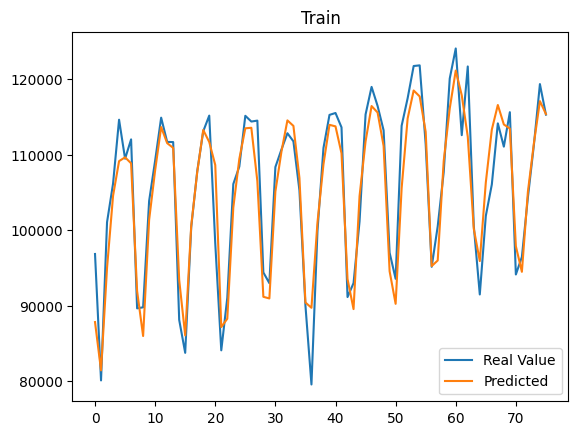

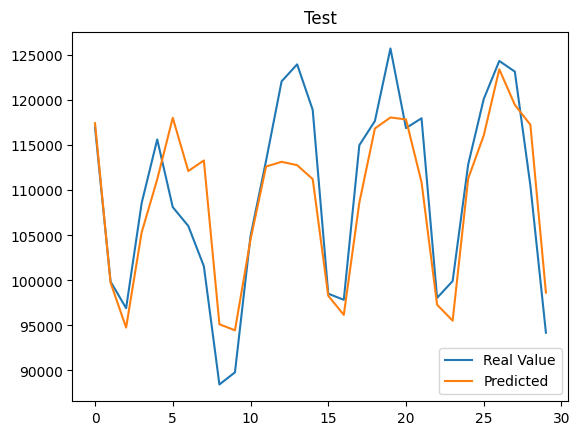

In [39]:
prediction_visualization(train_df, test_df, train_prediction_df, test_prediction_df)

### Evaluation

In [40]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [41]:
def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred))
    smape = np.mean(numerator / denominator)
    return smape * 100

In [42]:
def evaluation(model_name, train_df, test_df, train_prediction_df, test_prediction_df):
    print(f'{model_name} train scores:')


    evaluate(mean_absolute_error, 'MAE', train_df['Demand'], train_prediction_df)
    evaluate(mean_squared_error, 'MSE', train_df['Demand'], train_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', train_df['Demand'], train_prediction_df)
    evaluate(smape, 'smape', train_df['Demand'], train_prediction_df)

    print(f'{model_name} test scores:')

    evaluate(mean_absolute_error, 'MAE', test_df['Demand'], test_prediction_df)
    evaluate(mean_squared_error, 'MSE', test_df['Demand'], test_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', test_df['Demand'], test_prediction_df)
    evaluate(smape, 'smape', test_df['Demand'], test_prediction_df)


In [43]:
evaluation('XGB', train_df, test_df, train_prediction_df, test_prediction_df)

XGB train scores:
MAE : 22.95417340120466
MSE : 5180.60532794913
MAPE : 757374527786420.8
smape : 28.155693280914722
XGB test scores:
MAE : 30.835328815987396
MSE : 9209.321143544434
MAPE : 758309346030387.5
smape : 27.84198979333746


### Feature Importance and SHAPE

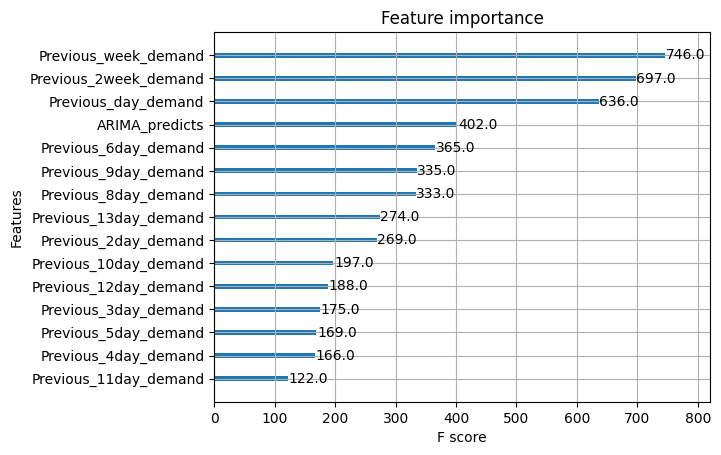

In [44]:
xgb.plot_importance(model)
plt.show()

In [45]:
'''dtrain_reg = xgb.DMatrix(train_df[FEATURE_LIST].values, train_df['Demand'].values, enable_categorical=True)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dtrain_reg)
shap.summary_plot(shap_values, train_df[FEATURE_LIST])'''

"dtrain_reg = xgb.DMatrix(train_df[FEATURE_LIST].values, train_df['Demand'].values, enable_categorical=True)\n\nexplainer = shap.TreeExplainer(model)\nshap_values = explainer.shap_values(dtrain_reg)\nshap.summary_plot(shap_values, train_df[FEATURE_LIST])"

# File Saving

In [46]:
def save_predictions(dataset, path):
    dataset.to_parquet(path, index=False)

In [47]:
def prediction_labeling(pred_df, labeled_df):
    pred_df = pd.DataFrame(pred_df, columns = ['Predicted_demand'])
    labeled_df.reset_index(inplace = True)
    labeled_prediction_df = labeled_df[['Location', 'Date']]
    labeled_prediction_df['Predicted_demand'] = pred_df
    return labeled_prediction_df

In [48]:
labeled_prediction_df = prediction_labeling(test_prediction_df, test_df)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [49]:
print(f'labeled prediction dataframe shape : {labeled_prediction_df.shape}')
labeled_prediction_df.head()

labeled prediction dataframe shape : (7860, 3)


,Location,Date,Predicted_demand
0,1,2023-04-01,18.684296
1,1,2023-04-02,15.586596
2,1,2023-04-03,12.222180
3,1,2023-04-04,10.692094
4,1,2023-04-05,12.219470


In [50]:
save_predictions(labeled_prediction_df, OUTPUT_PATH)